In [ ]:
import pandas as pd
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv

In [ ]:
# ---------------------------------------------------------------------
# CARGAR VARIABLES DEL ARCHIVO .env
# ---------------------------------------------------------------------
load_dotenv()  # carga las va|riables de entorno desde el archivo .env

DATA_PATH = os.getenv("DATA_PATH")

if DATA_PATH is None:
    raise EnvironmentError(
        "❌ No se encontró la variable DATA_PATH en el archivo .env. "
        "Asegúrate de definirla, por ejemplo:\nDATA_PATH=/ruta/a/tu/dataset.csv"
    )

# ---------------------------------------------------------------------
# FUNCIÓN DE CARGA DEL DATASET
# ---------------------------------------------------------------------
def load_dataset():
    """Carga el dataset desde la ruta especificada en .env"""
    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"❌ No se encontró el archivo en: {DATA_PATH}")

    print(f"📂 Cargando dataset desde: {DATA_PATH}")
    df = pd.read_csv(DATA_PATH)
    print(f"✅ Dataset cargado: {df.shape[0]} filas y {df.shape[1]} columnas.")
    return df

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
 11  total_sales      16713 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.5+ MB


In [12]:
#### Se eliminan los dos registros que no tienen 'genre', ya que coinciden que tampoco tienen 'name', 'critic_score', 'user_score', ni 'rating, además no tiene ventas muy altas
df.dropna(subset=['genre'], inplace=True)

In [14]:
df['platform'].nunique()

31

NaN Data visualization

In [15]:
##
#  1.5. Charts to comprehend the data and NaN
# ============================================================================
# PASO 2: ANÁLISIS ESTADÍSTICO POR GRUPO
# ============================================================================

# Atributos a analizar
atributos = ['critic_score', 'rating', 'user_score']

# Crear análisis por grupo
def analizar_nulos_por_grupo(df, atributos):
    """
    Analiza datos nulos y no nulos agrupados por genre y platform
    """
    resultados = []
    
    for genre in df['genre'].unique():
        for platform in df['platform'].unique():
            # Filtrar por grupo
            mask = (df['genre'] == genre) & (df['platform'] == platform)
            grupo = df[mask]
            
            if len(grupo) > 0:
                fila = {
                    'genre': genre,
                    'platform': platform,
                    'total_juegos': len(grupo)
                }
                
                # Analizar cada atributo
                for atributo in atributos:
                    nulos = grupo[atributo].isna().sum()
                    no_nulos = grupo[atributo].notna().sum()
                    porcentaje_nulos = (nulos / len(grupo)) * 100
                    
                    fila[f'{atributo}_nulos'] = nulos
                    fila[f'{atributo}_no_nulos'] = no_nulos
                    fila[f'{atributo}_pct_nulos'] = porcentaje_nulos
                
                resultados.append(fila)
    
    return pd.DataFrame(resultados)

# Generar estadísticas
df_stats = analizar_nulos_por_grupo(df, atributos)

print("\n" + "=" * 80)
print("ESTADÍSTICAS POR GRUPO (Genre + Platform)")
print("=" * 80)
print(df_stats.to_string(index=False))

# Guardar estadísticas en CSV
df_stats.to_csv(r'../data/estadisticas_nulos.csv', index=False)
print("\n✓ Estadísticas guardadas en: estadisticas_nulos.csv")

# ============================================================================
# PASO 3: RESUMEN GENERAL
# ============================================================================

print("\n" + "=" * 80)
print("RESUMEN GENERAL DE DATOS NULOS")
print("=" * 80)

for atributo in atributos:
    total_nulos = df[atributo].isna().sum()
    total_no_nulos = df[atributo].notna().sum()
    pct_nulos = (total_nulos / len(df)) * 100
    
    print(f"\n{atributo.upper()}:")
    print(f"  • No nulos: {total_no_nulos} ({100-pct_nulos:.1f}%)")
    print(f"  • Nulos:    {total_nulos} ({pct_nulos:.1f}%)")



ESTADÍSTICAS POR GRUPO (Genre + Platform)
       genre platform  total_juegos  critic_score_nulos  critic_score_no_nulos  critic_score_pct_nulos  rating_nulos  rating_no_nulos  rating_pct_nulos  user_score_nulos  user_score_no_nulos  user_score_pct_nulos
      Sports      Wii           260                 165                     95               63.461538            68              192         26.153846               162                   98             62.307692
      Sports      NES            14                  14                      0              100.000000            14                0        100.000000                14                    0            100.000000
      Sports       GB             9                   9                      0              100.000000             9                0        100.000000                 9                    0            100.000000
      Sports       DS           148                 108                     40               72.972973   


GENERANDO VISUALIZACIONES...

🔍 Datos a visualizar:
   • Géneros únicos: 12
   • Plataformas únicas: 31
   • Plataformas: ['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG', 'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360', 'XB', 'XOne']

📊 Verificación de pivots:
   • Géneros en pivot: 12
   • Plataformas en pivot: 31
✅ Plataformas mostradas en heatmap: 31


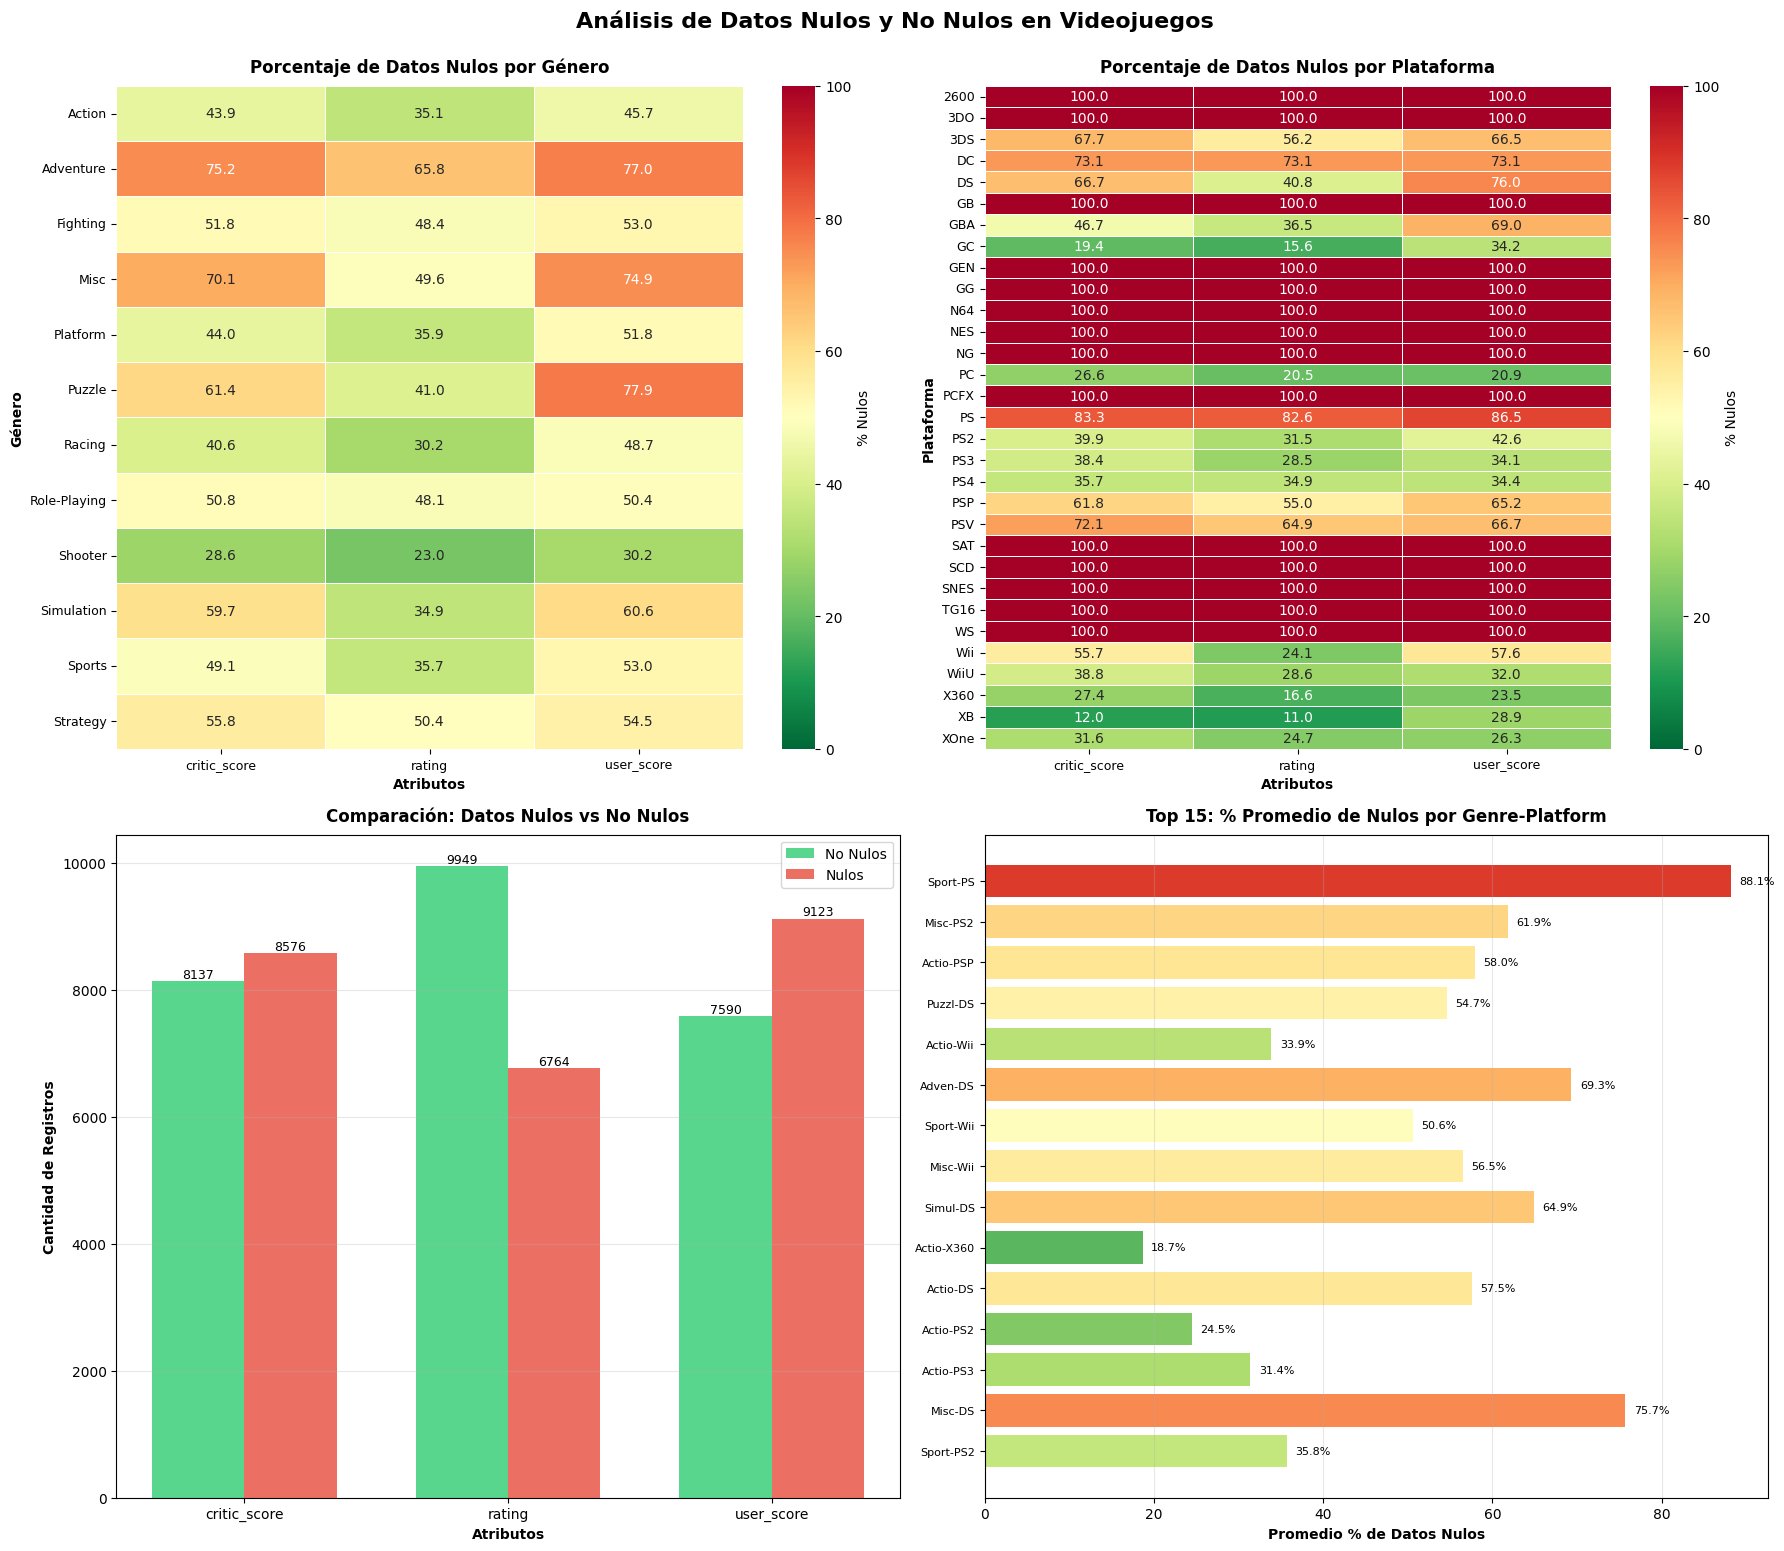

In [16]:
# ============================================================================
# PASO 4: VISUALIZACIONES (VERSIÓN MEJORADA)
# ============================================================================

print("\n" + "=" * 80)
print("GENERANDO VISUALIZACIONES...")
print("=" * 80)

# IMPORTANTE: Verificar plataformas y géneros únicos
print(f"\n🔍 Datos a visualizar:")
plataformas_unicas = df['platform'].dropna().unique()
generos_unicos = df['genre'].dropna().unique()
print(f"   • Géneros únicos: {len(generos_unicos)}")
print(f"   • Plataformas únicas: {len(plataformas_unicas)}")
print(f"   • Plataformas: {sorted(plataformas_unicas)}")

# Crear pivots
pivot_genre = df.groupby('genre')[atributos].apply(
    lambda x: (x.isna().sum() / len(x)) * 100
).sort_index()

pivot_platform = df.groupby('platform')[atributos].apply(
    lambda x: (x.isna().sum() / len(x)) * 100
).sort_index()

# Verificar pivots
print(f"\n📊 Verificación de pivots:")
print(f"   • Géneros en pivot: {len(pivot_genre)}")
print(f"   • Plataformas en pivot: {len(pivot_platform)}")

# Ajustar tamaño de figura según cantidad de datos
n_platforms = len(pivot_platform)
n_genres = len(pivot_genre)
altura_minima = max(12, n_platforms * 0.5, n_genres * 0.5)
ancho_figura = 18

fig, axes = plt.subplots(2, 2, figsize=(ancho_figura, altura_minima))
fig.suptitle('Análisis de Datos Nulos y No Nulos en Videojuegos', 
             fontsize=16, fontweight='bold', y=0.998)

# ============================================================================
# Subplot 1: Heatmap de % de nulos por Genre
# ============================================================================

ax1 = axes[0, 0]
sns.heatmap(pivot_genre, 
            annot=True, 
            fmt='.1f', 
            cmap='RdYlGn_r', 
            ax=ax1, 
            cbar_kws={'label': '% Nulos'},
            linewidths=0.5,
            linecolor='white',
            vmin=0,
            vmax=100)

ax1.set_title('Porcentaje de Datos Nulos por Género', fontweight='bold', pad=10)
ax1.set_xlabel('Atributos', fontweight='bold')
ax1.set_ylabel('Género', fontweight='bold')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=9)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=9)

# ============================================================================
# Subplot 2: Heatmap de % de nulos por Platform (MEJORADO)
# ============================================================================

ax2 = axes[0, 1]

# CLAVE: Configuración para mostrar TODAS las plataformas
sns.heatmap(pivot_platform, 
            annot=True,           # Mostrar números
            fmt='.1f',            # 1 decimal
            cmap='RdYlGn_r',      # Colores (rojo=malo, verde=bueno)
            ax=ax2, 
            cbar_kws={'label': '% Nulos'},
            linewidths=0.5,       # Líneas entre celdas
            linecolor='white',
            vmin=0,               # Mínimo 0%
            vmax=100)             # Máximo 100%

ax2.set_title('Porcentaje de Datos Nulos por Plataforma', fontweight='bold', pad=10)
ax2.set_xlabel('Atributos', fontweight='bold')
ax2.set_ylabel('Plataforma', fontweight='bold')

# IMPORTANTE: Configurar etiquetas para que TODAS se vean
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=9)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=9)

# Verificar
print(f"✅ Plataformas mostradas en heatmap: {len(ax2.get_yticklabels())}")

# ============================================================================
# Subplot 3: Barras comparativas - Nulos vs No Nulos por atributo
# ============================================================================

ax3 = axes[1, 0]
data_comparacion = []
for atributo in atributos:
    data_comparacion.append({
        'Atributo': atributo,
        'No Nulos': df[atributo].notna().sum(),
        'Nulos': df[atributo].isna().sum()
    })

df_comp = pd.DataFrame(data_comparacion)
x = np.arange(len(atributos))
width = 0.35

bars1 = ax3.bar(x - width/2, df_comp['No Nulos'], width, label='No Nulos', color='#2ecc71', alpha=0.8)
bars2 = ax3.bar(x + width/2, df_comp['Nulos'], width, label='Nulos', color='#e74c3c', alpha=0.8)

ax3.set_xlabel('Atributos', fontweight='bold')
ax3.set_ylabel('Cantidad de Registros', fontweight='bold')
ax3.set_title('Comparación: Datos Nulos vs No Nulos', fontweight='bold', pad=10)
ax3.set_xticks(x)
ax3.set_xticklabels(atributos)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=9)

# ============================================================================
# Subplot 4: Distribución de nulos por combinación Genre-Platform (Top 15)
# ============================================================================

ax4 = axes[1, 1]
df_stats_sorted = df_stats.sort_values('total_juegos', ascending=False).head(15)

# Calcular promedio de % nulos para cada grupo
df_stats_sorted['promedio_pct_nulos'] = df_stats_sorted[[
    'critic_score_pct_nulos', 
    'rating_pct_nulos', 
    'user_score_pct_nulos'
]].mean(axis=1)

labels = [f"{row['genre'][:5]}-{row['platform'][:4]}" 
          for _, row in df_stats_sorted.iterrows()]
colors = plt.cm.RdYlGn_r(df_stats_sorted['promedio_pct_nulos'] / 100)

bars = ax4.barh(range(len(labels)), df_stats_sorted['promedio_pct_nulos'], color=colors)
ax4.set_yticks(range(len(labels)))
ax4.set_yticklabels(labels, fontsize=8)
ax4.set_xlabel('Promedio % de Datos Nulos', fontweight='bold')
ax4.set_title('Top 15: % Promedio de Nulos por Genre-Platform', fontweight='bold', pad=10)
ax4.grid(axis='x', alpha=0.3)

# Agregar valores
for i, (bar, val) in enumerate(zip(bars, df_stats_sorted['promedio_pct_nulos'])):
    ax4.text(val + 1, i, f'{val:.1f}%', va='center', fontsize=8)

plt.tight_layout()


In [17]:
df[df['platform'] == '2600'].isnull().sum()

name                 0
platform             0
year_of_release      0
genre                0
na_sales             0
eu_sales             0
jp_sales             0
other_sales          0
critic_score       133
user_score         133
rating             133
total_sales          0
dtype: int64

In [18]:
df['name'].duplicated().sum()

np.int64(5154)

In [19]:
def most_frequent(x):
    return x.mode().iloc[0] if not x.mode().empty else None

# Agrupamos por 'name'
result = (
    df.groupby('name', as_index=False)
      .agg({
          'platform': 'count',                # cantidad de plataformas
          'critic_score': 'mean',             # promedio de puntuación crítica
          'user_score': 'mean',               # promedio de puntuación de usuario
          'rating': most_frequent             # valor más repetido de rating
      })
)

# Renombramos columnas para mayor claridad (opcional)
result = result.rename(columns={
    'platform': 'platform_count',
    'critic_score': 'avg_critic_score',
    'user_score': 'avg_user_score',
    'rating': 'most_common_rating'
})

result.head(10)

,name,platform_count,avg_critic_score,avg_user_score,most_common_rating
0,Beyblade Burst,1,NaN,NaN,None
1,Fire Emblem Fates,1,NaN,NaN,None
2,Frozen: Olaf's Quest,2,NaN,NaN,None
3,Haikyu!! Cross Team Match!,1,NaN,NaN,None
4,Tales of Xillia 2,1,71.0,7.9,T
5,'98 Koshien,1,NaN,NaN,None
6,.hack//G.U. Vol.1//Rebirth,1,NaN,NaN,None
7,.hack//G.U. Vol.2//Reminisce,1,NaN,NaN,None
8,.hack//G.U. Vol.2//Reminisce (jp sales),1,NaN,NaN,None
9,.hack//G.U. Vol.3//Redemption,1,NaN,NaN,None


In [20]:
df[df['name'].str.strip() == "Frozen: Olaf's Quest"]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
3357,Frozen: Olaf's Quest,3DS,2013,Platform,0.27,0.27,0.0,0.05,NaN,NaN,NaN,0.59
3861,Frozen: Olaf's Quest,DS,2013,Platform,0.21,0.26,0.0,0.04,NaN,NaN,NaN,0.51



✓ ANÁLISIS COMPLETADO

Archivos generados:
  1. estadisticas_nulos.csv - Tabla con todas las estadísticas
  2. analisis_nulos_videojuegos.png - Gráfico principal con 4 visualizaciones
  3. analisis_detallado_atributos.png - Análisis por atributo y género
  4. matriz_completitud.png - Matriz de completitud por grupo


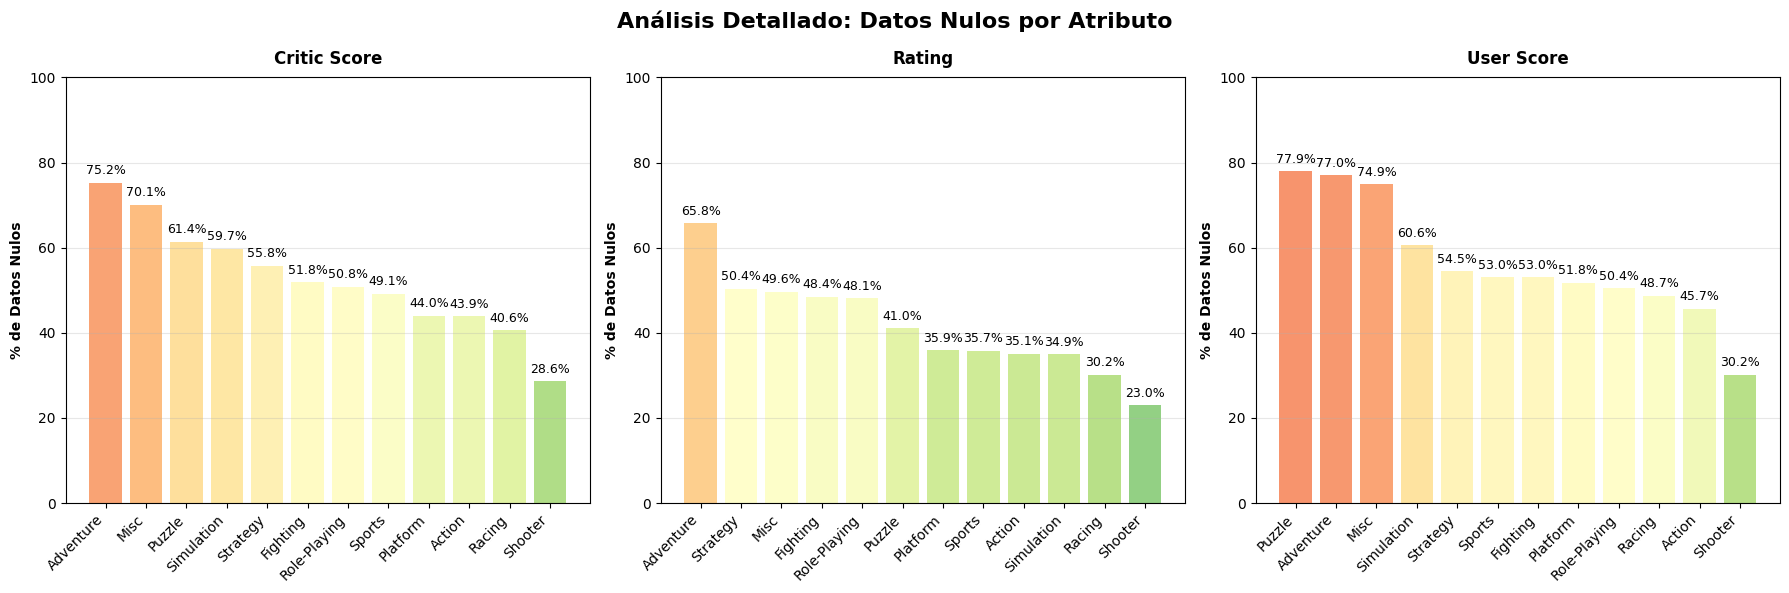

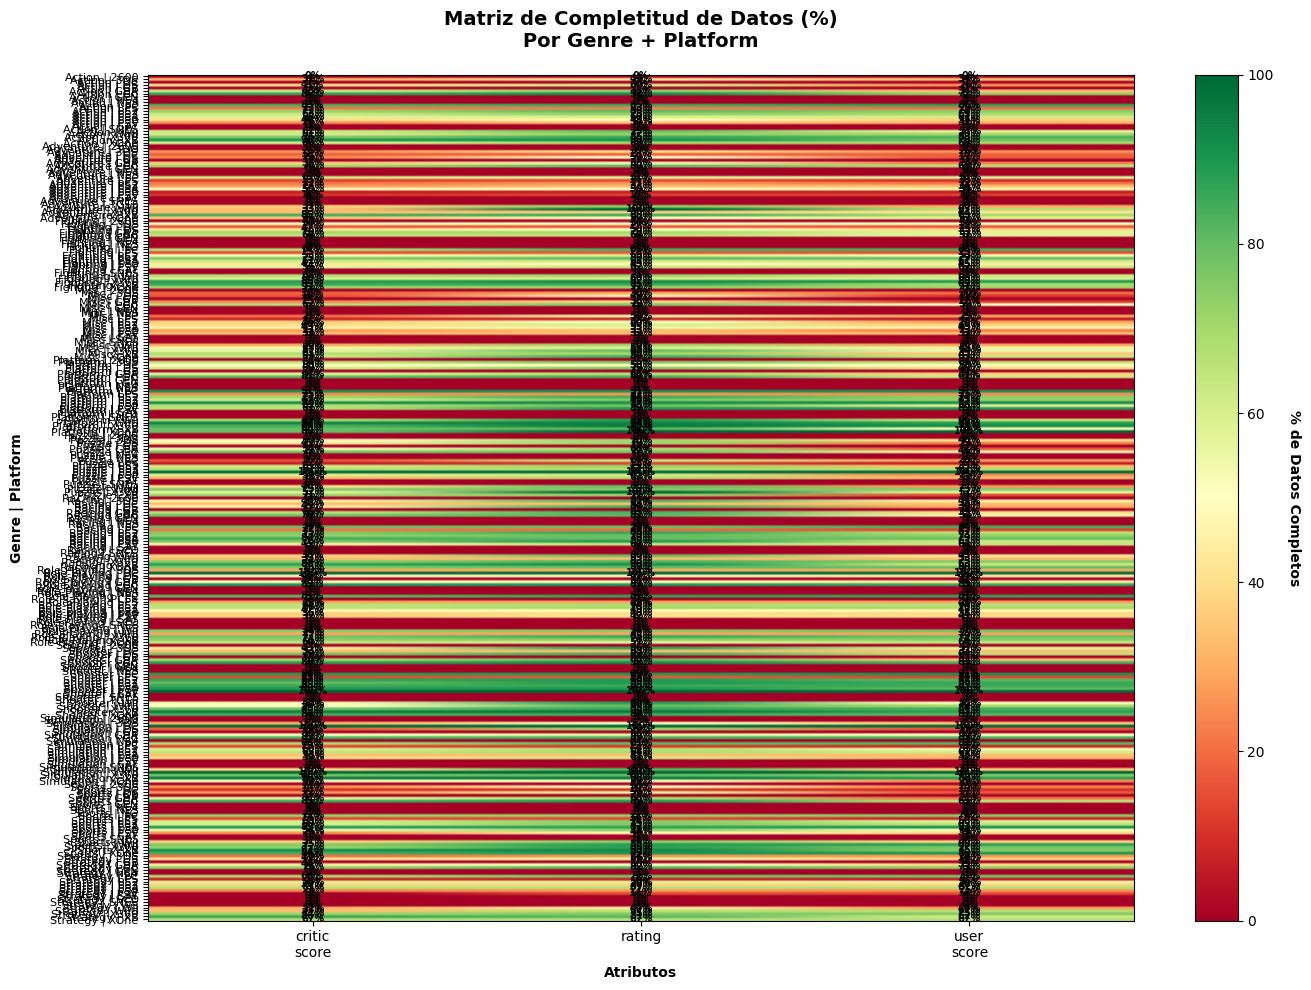

In [21]:
# ============================================================================
# Figura 2: Análisis detallado por cada atributo
# ============================================================================

fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6))
fig2.suptitle('Análisis Detallado: Datos Nulos por Atributo', fontsize=16, fontweight='bold')

for idx, atributo in enumerate(atributos):
    ax = axes2[idx]
    
    # Agrupar por genre y calcular % de nulos
    nulos_por_genre = df.groupby('genre')[atributo].apply(
        lambda x: (x.isna().sum() / len(x)) * 100
    ).sort_values(ascending=False)
    
    colors = plt.cm.RdYlGn_r(nulos_por_genre.values / 100)
    bars = ax.bar(range(len(nulos_por_genre)), nulos_por_genre.values, color=colors, alpha=0.8)
    
    ax.set_xticks(range(len(nulos_por_genre)))
    ax.set_xticklabels(nulos_por_genre.index, rotation=45, ha='right')
    ax.set_ylabel('% de Datos Nulos', fontweight='bold')
    ax.set_title(f'{atributo.replace("_", " ").title()}', fontweight='bold', pad=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 100)
    
    # Agregar valores
    for i, (bar, val) in enumerate(zip(bars, nulos_por_genre.values)):
        ax.text(i, val + 2, f'{val:.1f}%', ha='center', fontsize=9)

plt.tight_layout()


# ============================================================================
# Figura 3: Matriz de completitud
# ============================================================================

fig3, ax = plt.subplots(figsize=(14, 10))

# Preparar datos para la matriz
genres_sorted = sorted(df['genre'].unique())
platforms_sorted = sorted(df['platform'].unique())
n_attrs = len(atributos)

# Crear matriz
matriz_data = np.zeros((len(genres_sorted) * len(platforms_sorted), n_attrs))
labels_y = []
row_idx = 0

for genre in genres_sorted:
    for platform in platforms_sorted:
        mask = (df['genre'] == genre) & (df['platform'] == platform)
        grupo = df[mask]
        
        if len(grupo) > 0:
            for col_idx, atributo in enumerate(atributos):
                completitud = (grupo[atributo].notna().sum() / len(grupo)) * 100
                matriz_data[row_idx, col_idx] = completitud
            
            labels_y.append(f"{genre} | {platform}")
            row_idx += 1

# Recortar matriz
matriz_data = matriz_data[:row_idx, :]

# Crear heatmap
im = ax.imshow(matriz_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)

# Configurar ejes
ax.set_xticks(np.arange(n_attrs))
ax.set_yticks(np.arange(len(labels_y)))
ax.set_xticklabels([attr.replace('_', '\n') for attr in atributos])
ax.set_yticklabels(labels_y, fontsize=8)

# Agregar valores en las celdas
for i in range(len(labels_y)):
    for j in range(n_attrs):
        text = ax.text(j, i, f'{matriz_data[i, j]:.0f}%',
                      ha="center", va="center", color="black", fontsize=7, fontweight='bold')

ax.set_title('Matriz de Completitud de Datos (%)\nPor Genre + Platform', 
             fontweight='bold', pad=20, fontsize=14)
ax.set_xlabel('Atributos', fontweight='bold')
ax.set_ylabel('Genre | Platform', fontweight='bold')

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('% de Datos Completos', rotation=270, labelpad=20, fontweight='bold')

plt.tight_layout()

print("\n" + "=" * 80)
print("✓ ANÁLISIS COMPLETADO")
print("=" * 80)
print("\nArchivos generados:")
print("  1. estadisticas_nulos.csv - Tabla con todas las estadísticas")
print("  2. analisis_nulos_videojuegos.png - Gráfico principal con 4 visualizaciones")
print("  3. analisis_detallado_atributos.png - Análisis por atributo y género")
print("  4. matriz_completitud.png - Matriz de completitud por grupo")

plt.show()


In [ ]:
# ============================================================
# IMPUTACIÓN JERÁRQUICA DE DATOS DE CALIDAD DE VIDEOJUEGOS
# ============================================================

def impute_hierarchical(df, column, min_samples=5):
    """
    Imputa valores nulos usando estrategia jerárquica de 4 niveles.
    
    Niveles:
    1. Platform + Genre + Year
    2. Genre + Year
    3. Genre
    4. Global (mediana o moda general)
    
    Args:
        df: DataFrame
        column: Nombre de la columna a imputar
        min_samples: Mínimo de muestras para calcular estadística por grupo
    
    Returns:
        Series con valores imputados
        Series con registro de niveles de imputación
    """
    
    # Crear copia de la columna
    imputed_col = df[column].copy()
    
    # Registrar en qué nivel se imputó cada valor
    imputation_level = pd.Series('original', index=df.index)
    imputation_level[df[column].isna()] = 'not_imputed'
    
    # Determinar si es categórico o numérico
    is_categorical = df[column].dtype == 'object' or column == 'rating'
    
    # Definir función de agregación
    if is_categorical:
        def agg_func(x):
            mode_result = x.mode()
            return mode_result.iloc[0] if len(mode_result) > 0 else np.nan
        stat_name = "moda"
        col_name = 'mode'
    else:
        agg_func = 'median'
        stat_name = "mediana"
        col_name = 'median'
    
    # Máscara de valores a imputar
    mask = df[column].isna()
    total_to_impute = mask.sum()
    imputed_count = 0
    
    print(f"\n{'='*70}")
    print(f"IMPUTANDO: {column.upper()}")
    print(f"{'='*70}")
    print(f"Total valores a imputar: {total_to_impute}")
    print(f"Usando {stat_name} como medida central")
    
    # NIVEL 1: Platform + Genre + Year
    print(f"\nNivel 1: Platform + Genre + Year...")
    if 'year_of_release' in df.columns:
        level1_stats = df.groupby(['platform', 'genre', 'year_of_release'])[column].agg(
            value=agg_func,
            count='count'
        )
        level1_stats = level1_stats[level1_stats['count'] >= min_samples]
        
        for idx in df[mask].index:
            platform = df.loc[idx, 'platform']
            genre = df.loc[idx, 'genre']
            year = df.loc[idx, 'year_of_release']
            
            if (platform, genre, year) in level1_stats.index:
                value = level1_stats.loc[(platform, genre, year), 'value']
                if pd.notna(value):
                    imputed_col.loc[idx] = value
                    imputation_level.loc[idx] = 'level_1'
                    imputed_count += 1
        
        print(f"  Imputados en Nivel 1: {imputed_count}")
    
    # Actualizar máscara
    mask = imputed_col.isna()
    
    # NIVEL 2: Genre + Year
    print(f"Nivel 2: Genre + Year...")
    if 'year_of_release' in df.columns:
        level2_stats = df.groupby(['genre', 'year_of_release'])[column].agg(
            value=agg_func,
            count='count'
        )
        level2_stats = level2_stats[level2_stats['count'] >= min_samples]
        
        level2_count = 0
        for idx in df[mask].index:
            genre = df.loc[idx, 'genre']
            year = df.loc[idx, 'year_of_release']
            
            if (genre, year) in level2_stats.index:
                value = level2_stats.loc[(genre, year), 'value']
                if pd.notna(value):
                    imputed_col.loc[idx] = value
                    imputation_level.loc[idx] = 'level_2'
                    level2_count += 1
        
        imputed_count += level2_count
        print(f"  Imputados en Nivel 2: {level2_count}")
    
    # Actualizar máscara
    mask = imputed_col.isna()
    
    # NIVEL 3: Genre
    print(f"Nivel 3: Genre...")
    level3_stats = df.groupby('genre')[column].agg(
        value=agg_func,
        count='count'
    )
    level3_stats = level3_stats[level3_stats['count'] >= min_samples]
    
    level3_count = 0
    for idx in df[mask].index:
        genre = df.loc[idx, 'genre']
        
        if genre in level3_stats.index:
            value = level3_stats.loc[genre, 'value']
            if pd.notna(value):
                imputed_col.loc[idx] = value
                imputation_level.loc[idx] = 'level_3'
                level3_count += 1
    
    imputed_count += level3_count
    print(f"  Imputados en Nivel 3: {level3_count}")
    
    # Actualizar máscara
    mask = imputed_col.isna()
    
    # NIVEL 4: Global
    print(f"Nivel 4: Global...")
    if is_categorical:
        mode_result = df[column].mode()
        global_value = mode_result.iloc[0] if len(mode_result) > 0 else np.nan
    else:
        global_value = df[column].median()
    
    level4_count = 0
    if pd.notna(global_value):
        for idx in df[mask].index:
            imputed_col.loc[idx] = global_value
            imputation_level.loc[idx] = 'level_4'
            level4_count += 1
    
    imputed_count += level4_count
    print(f"  Imputados en Nivel 4: {level4_count}")
    
    # Resumen final
    still_null = imputed_col.isna().sum()
    print(f"\n{'='*70}")
    print(f"RESUMEN DE IMPUTACIÓN - {column.upper()}")
    print(f"{'='*70}")
    print(f"Total imputado: {imputed_count} / {total_to_impute}")
    print(f"Valores aún nulos: {still_null}")
    print(f"Tasa de éxito: {imputed_count/total_to_impute*100:.2f}%" if total_to_impute > 0 else "N/A")
    
    return imputed_col, imputation_level


def impute_rating_with_scores(df, min_samples=5):
    """
    Imputa rating usando estrategia híbrida:
    1. Jerarquía normal (moda)
    2. Si disponible, usar scores para predecir rating probable
    """
    
    # Primero, imputación jerárquica normal
    imputed_rating, rating_levels = impute_hierarchical(df, 'rating', min_samples)
    
    # Intentar mejorar usando scores (si están disponibles)
    print(f"\n{'='*70}")
    print("MEJORA DE RATING USANDO SCORES")
    print(f"{'='*70}")
    
    mask = imputed_rating.isna()
    improved = 0
    
    # Definir rangos de scores para ratings
    for idx in df[mask].index:
        critic = df.loc[idx, 'critic_score']
        user = df.loc[idx, 'user_score']
        
        # Si tenemos al menos un score, podemos estimar
        if pd.notna(critic) or pd.notna(user):
            avg_score = np.nanmean([critic, user if pd.notna(user) else np.nan])
            
            # Lógica simple de clasificación
            if avg_score >= 75:
                imputed_rating.loc[idx] = 'T'
            elif avg_score >= 65:
                imputed_rating.loc[idx] = 'E10+'
            else:
                imputed_rating.loc[idx] = 'E'
            
            rating_levels.loc[idx] = 'score_based'
            improved += 1
    
    print(f"Ratings mejorados usando scores: {improved}")
    
    return imputed_rating, rating_levels


# ============================================================
# SCRIPT PRINCIPAL
# ============================================================

if __name__ == "__main__":
      
    print(f"\n{'='*70}")
    print("ESTADO INICIAL DEL DATASET")
    print(f"{'='*70}")
    print(f"Total de registros: {len(df)}")
    print(f"\nValores nulos:")
    print(f"  critic_score: {df['critic_score'].isna().sum()} ({df['critic_score'].isna().sum()/len(df)*100:.2f}%)")
    print(f"  user_score:   {df['user_score'].isna().sum()} ({df['user_score'].isna().sum()/len(df)*100:.2f}%)")
    print(f"  rating:       {df['rating'].isna().sum()} ({df['rating'].isna().sum()/len(df)*100:.2f}%)")
    
    # Crear copia para trabajar
    df_imputed = df.copy()
    
    # FASE 1: Imputar critic_score
    df_imputed['critic_score'], df_imputed['critic_score_imputation_level'] = \
        impute_hierarchical(df_imputed, 'critic_score', min_samples=5)
    
    # FASE 2: Imputar user_score
    df_imputed['user_score'], df_imputed['user_score_imputation_level'] = \
        impute_hierarchical(df_imputed, 'user_score', min_samples=5)
    
    # FASE 3: Imputar rating
    df_imputed['rating'], df_imputed['rating_imputation_level'] = \
        impute_rating_with_scores(df_imputed, min_samples=5)
    
    # ============================================================
    # VALIDACIÓN Y REPORTE FINAL
    # ============================================================
    
    print(f"\n{'='*70}")
    print("VALIDACIÓN DE COHERENCIA")
    print(f"{'='*70}")
    
    # Correlación entre scores
    corr_before = df[['critic_score', 'user_score']].corr().iloc[0, 1]
    corr_after = df_imputed[['critic_score', 'user_score']].corr().iloc[0, 1]
    
    print(f"\nCorrelación critic_score vs user_score:")
    print(f"  Antes: {corr_before:.4f}")
    print(f"  Después: {corr_after:.4f}")
    print(f"  Cambio: {corr_after - corr_before:+.4f}")
    
    # Distribución de niveles de imputación
    print(f"\n{'='*70}")
    print("DISTRIBUCIÓN DE NIVELES DE IMPUTACIÓN")
    print(f"{'='*70}")
    
    for col in ['critic_score', 'user_score', 'rating']:
        level_col = f"{col}_imputation_level"
        print(f"\n{col.upper()}:")
        print(df_imputed[level_col].value_counts().sort_index())
    
    # Estado final
    print(f"\n{'='*70}")
    print("ESTADO FINAL DEL DATASET")
    print(f"{'='*70}")
    print(f"  critic_score nulos: {df_imputed['critic_score'].isna().sum()}")
    print(f"  user_score nulos:   {df_imputed['user_score'].isna().sum()}")
    print(f"  rating nulos:       {df_imputed['rating'].isna().sum()}")
    
    # Guardar resultado
    output_path = r'data/games_quality_imputed.csv'
    df_imputed.to_csv(output_path, index=False)
    print(f"\n✓ Dataset guardado en: {output_path}")
    
    print(f"\n{'='*70}")
    print("¡IMPUTACIÓN COMPLETADA!")
    print(f"{'='*70}")


ESTADO INICIAL DEL DATASET
Total de registros: 16713

Valores nulos:
  critic_score: 8576 (51.31%)
  user_score:   9123 (54.59%)
  rating:       6764 (40.47%)

IMPUTANDO: CRITIC_SCORE
Total valores a imputar: 8576
Usando mediana como medida central

Nivel 1: Platform + Genre + Year...
  Imputados en Nivel 1: 4132
Nivel 2: Genre + Year...
  Imputados en Nivel 2: 2581
Nivel 3: Genre...
  Imputados en Nivel 3: 1863
Nivel 4: Global...
  Imputados en Nivel 4: 0

RESUMEN DE IMPUTACIÓN - CRITIC_SCORE
Total imputado: 8576 / 8576
Valores aún nulos: 0
Tasa de éxito: 100.00%

IMPUTANDO: USER_SCORE
Total valores a imputar: 9123
Usando mediana como medida central

Nivel 1: Platform + Genre + Year...
  Imputados en Nivel 1: 4145
Nivel 2: Genre + Year...
  Imputados en Nivel 2: 3147
Nivel 3: Genre...
  Imputados en Nivel 3: 1831
Nivel 4: Global...
  Imputados en Nivel 4: 0

RESUMEN DE IMPUTACIÓN - USER_SCORE
Total imputado: 9123 / 9123
Valores aún nulos: 0
Tasa de éxito: 100.00%

IMPUTANDO: RATING
T